# ADM Homework 4 - Movie Recommendation System, Group #15

### Team Members
* Sandro Khizanishvili, khizanishvilisandro@gmail.com
* Domenico Azzarito, domazza6902@outlook.it
* Alessandro Querqui, 2031384, querqui.2031384@studenti.uniroma1.it
* Géraldine Valérie Maurer, 1996887, gmaurer08@gmail.com

## Import Data and Libraries

In [1]:
!pip install kaggle

In [2]:
!kaggle datasets download grouplens/movielens-20m-dataset

Dataset URL: https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset
License(s): unknown
100% 195M/195M [00:09<00:00, 23.9MB/s]
100% 195M/195M [00:09<00:00, 21.5MB/s]


In [ ]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import random
from tqdm import tqdm
from hash import *
from recommendations import *
import time

Unzip the file with the dataset downloaded from Kaggle:

In [6]:
# Unzip the file we downloaded from kaggle
zip_file_path = 'movielens-20m-dataset.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('.')  # Extract files to the current working directory

Save all the CSV files in pandas DataFrames:

In [7]:
# Save CSV files in pandas df
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
link = pd.read_csv('link.csv')
movie = pd.read_csv('movie.csv')
rating = pd.read_csv('rating.csv')
tag = pd.read_csv('tag.csv')

Display the first five rows of each DataFrame:

In [8]:
print("genome_scores:")
display(genome_scores.head())
print("genome_tags:")
display(genome_tags.head())
print("link:")
display(link.head())
print("movie:")
display(movie.head())
print("rating:")
display(rating.head())
print("tag:")
display(tag.head())

genome_scores:


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


genome_tags:


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


link:


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


movie:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


rating:


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


tag:


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


# 1. Recommendation System with LSH

## 1.1 Data Preparation

In this project, we are working with the MovieLens 20M dataset, which according to Kaggle contains over 20 million movie ratings and tagging activities since 1995. It consists of six CSV files, which we saved in pandas DataFrames. Here is an overview of the different data tables and their columns:

* ```genome_scores.csv```
    * ```movieId```: unique identifier of the movie
    * ```tagId```: unique identifier of the tag
    * ```relevance```: measure that quantifies how relevant or closely associated the tag is to the movie
* ```genome_tags.csv```
    * ```tagId```: unique identifier of the tag
    * ```tag```: name of the tag
* ```link.csv```
    * ```movieId```: unique identifier of the movie
    * ```imdbId```: IMDb (Internet Movie Database) identifier of the movie
    * ```tmbdId```: TMDB (The Movie Database) identifier of the movie
* ```movie.csv```:
    * ```movieId```: unique identifier of the movie
    * ```title```: title of the movie
    * ```genre```: genre of the movie
* ```rating.csv```:
    * ```userId```: unique identifier of the user who left the rating
    * ```movieId```: unique identifier of the movie that is being rated
    * ```rating```: rating given by the user to the movie, from 0.5 to 5.0
    * ```timestamp```: date and time when the rating was recorded
* ```tag.csv```:
    * ```userId```: unique identifier of the user who created the tag
    * ```movieId```: unique identifier of the movie to which the tag was applied
    * ```tag```: name of the tag
    * ```timestamp```: date and time of when the tag was created

Before starting to work on this dataset, it is useful to verify data quality and integrity. For this, we can take a look at some information about the DataFrames, including row and column numbers, as well as data types:

In [9]:
# Get info on the dataset
print("genome_scores information:")
print(genome_scores.info())
print("\ngenome_tags information:")
print(genome_tags.info())
print("\nlink information:")
print(link.info())
print("\nmovie information:")
print(movie.info())
print("\nrating information:")
print(rating.info())
print("\ntag information:")
print(tag.info())

genome_scores information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 268.0 MB
None

genome_tags information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB
None

link information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  27278 non-null  int64  
 1   imdbId   27278 non-null  int64  
 2   tmdbId   27026 non-null  float64
dtypes: float64(1), int64(2)
memo

We expect columns associated with unique identifiers for movies, tags, users or IDs on movie databases, to be of type integer. However, we see that in the ```link``` DataFrame there is an ID column, ```tmdbId```, with type float. This could be due to the fact that there are missing values in this columns. Let us see if there are any missing columns in general:

In [10]:
# Look for NaN values
genome_scores_na = genome_scores.isna().sum()
genome_tags_na = genome_tags.isna().sum()
link_na = link.isna().sum()
movie_na = movie.isna().sum()
rating_na = rating.isna().sum()
tag_na = tag.isna().sum()
print("genome_scores number of missing values per column:")
print(genome_scores_na)
print("\ngenome_tags number of missing values per column:")
print(genome_tags_na)
print("\nlink number of missing values per column:")
print(link_na)
print("\nmovie number of missing values per column:")
print(movie_na)
print("\nrating number of missing values per column:")
print(rating_na)
print("\ntag number of missing values per column:")
print(tag_na)

genome_scores number of missing values per column:
movieId      0
tagId        0
relevance    0
dtype: int64

genome_tags number of missing values per column:
tagId    0
tag      0
dtype: int64

link number of missing values per column:
movieId      0
imdbId       0
tmdbId     252
dtype: int64

movie number of missing values per column:
movieId    0
title      0
genres     0
dtype: int64

rating number of missing values per column:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

tag number of missing values per column:
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64


Two columns, ```tmdbId``` from the ```link``` DataFrame and ```tag``` from the ```tag``` DataFrame have some missing values. The first might be due to the fact that some movies are present in the IMDb database, but not in the TMDB database. In order not to lose information about certain movie IDs in the IMDb database, we choose to keep rows with missing ```tmdbId``` values for now. To convert the column data type to integer, we can use the pandas nullable ```Int64``` type:

In [11]:
link['tmdbId'] = link['tmdbId'].astype('Int64')
link['tmdbId'].dtype

Int64Dtype()

We prefer to remove the rows with missing ```tag``` column values from the ```tag``` DataFrame, because the tag name is an essential feature of this table. If a row misses this value, then the remaining values that are related to the non-present tag name, have little meaning.

In [12]:
tag = tag.dropna(subset=['tag'])

Next we check for duplicates:

In [13]:
# Check for duplicates
genome_scores_duplicates = genome_scores.duplicated().sum()
genome_tags_duplicates = genome_tags.duplicated().sum()
link_duplicates = link.duplicated().sum()
movie_duplicates = movie.duplicated().sum()
rating_duplicates = rating.duplicated().sum()
tag_duplicates = tag.duplicated().sum()
print("genome_scores number of duplicates:", genome_scores_duplicates)
print("genome_tags number of duplicates:", genome_tags_duplicates)
print("link number of duplicates:", link_duplicates)
print("movie number of duplicates:", movie_duplicates)
print("rating number of duplicates:", rating_duplicates)
print("tag number of duplicates:", tag_duplicates)

genome_scores number of duplicates: 0
genome_tags number of duplicates: 0
link number of duplicates: 0
movie number of duplicates: 0
rating number of duplicates: 0
tag number of duplicates: 0


A data processing step that could make movie genre analysis easier, is to split the ```genre``` column values in the ```movie``` DataFrame on '|' separators, and store the genres in a list of strings:

In [14]:
# Split genre column in movie on '|'
movie['genres'] = movie['genres'].str.split('|')
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


To distinguish movie title and year, we can split the ```title``` column into two columns, ```title``` and ```year```.

In [15]:
# Function to extract title and year
def extract_title_and_year(title):
    match = re.match(r'^(.*)\s\((\d{4})\)$', title)
    if match:
        return [match.group(1), match.group(2)]  # Return title and year as a list
    else:
        return [title, None]  # In case there's no year, return title and None

In [16]:
# Split title in the movie DataFrame into two columns using the extract_title_and_year function
movie[['title', 'year']] = pd.DataFrame(movie['title'].apply(extract_title_and_year).to_list(), index=movie.index)
movie.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


Now we want to convert the ```timestamp``` columns from type ```object``` to type ```datetime```.

In [17]:
rating['timestamp'] = pd.to_datetime(rating['timestamp'])
tag['timestamp'] = pd.to_datetime(tag['timestamp'])

We can check that there are no outliers in the timestamp attributes by plotting the histograms of both columns:

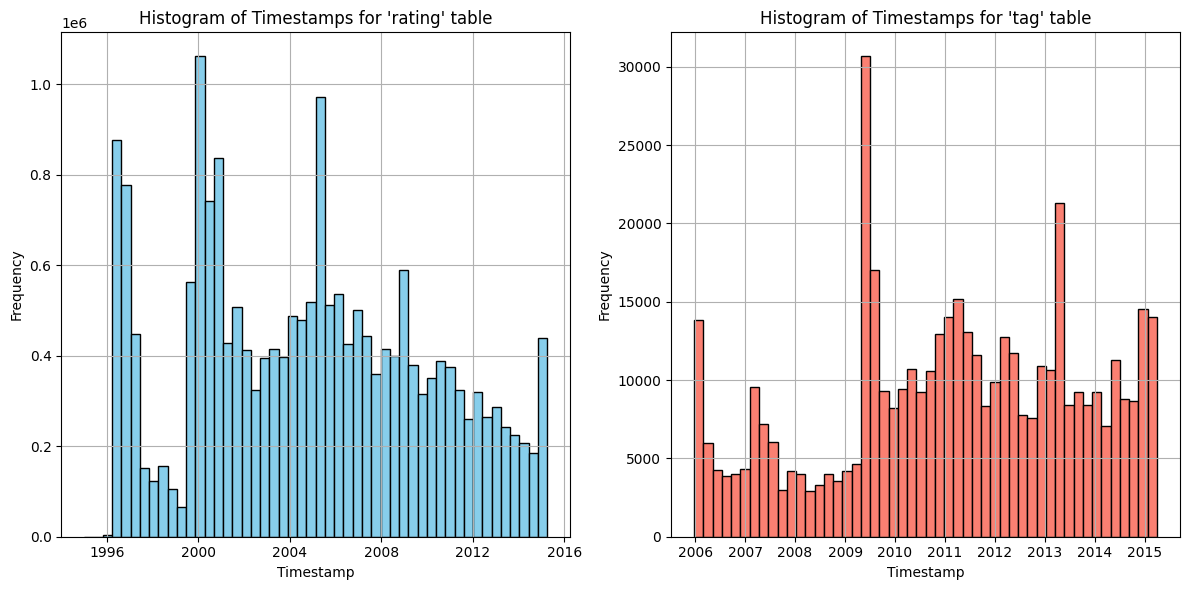

In [18]:
# Histogram for timestamps

# Create the figure and axes for two histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for 'rating' table timestamps
rating['timestamp'].hist(ax=axes[0], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title("Histogram of Timestamps for 'rating' table")
axes[0].set_xlabel('Timestamp')
axes[0].set_ylabel('Frequency')

# Plot histogram for 'tag' table timestamps
tag['timestamp'].hist(ax=axes[1], bins=50, color='salmon', edgecolor='black')
axes[1].set_title("Histogram of Timestamps for 'tag' table")
axes[1].set_xlabel('Timestamp')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


As written in the dataset descritpion, the earliest ratings date back to 1995. Moreover, there are no outliers.

Next, we can do some more data integrity checks. We want to make sure that relevance scores are in the range $[0,1]$, and that ratings are distributed in the list of values [0.5,1.0,1.5,2.0,2.5,3,3.5,4.0,4.5,5]

In [19]:
# check if relevance scores are in the range [0,1]
relevance_in_zero_to_one = genome_scores['relevance'].between(0, 1).all()
print("'relevance' column integrity check")
print('Check if the values are all between 0 and 1:')
print(relevance_in_zero_to_one)
# Check if rating values are in [0.5,1.0,1.5,2.0,2.5,3,3.5,4.0,4.5,5]
rating_in_one_to_five = rating['rating'].isin([0.5,1.0,1.5,2.0,2.5,3,3.5,4.0,4.5,5]).all()
print("\n'rating' column integrity check")
print('Check if the values are in the list [0.5,1.0,1.5,2.0,2.5,3,3.5,4.0,4.5,5]:')
print(rating_in_one_to_five)

'relevance' column integrity check
Check if the values are all between 0 and 1:
True

'rating' column integrity check
Check if the values are in the list [0.5,1.0,1.5,2.0,2.5,3,3.5,4.0,4.5,5]:
True


The ```relevance``` scores are all in the range [0,1], and the ```rating``` values are evenly spaced between 0.5 and 5, with gaps of size 0.5. We can plot a histogram to visualize which rating scores are assigned most frequently.

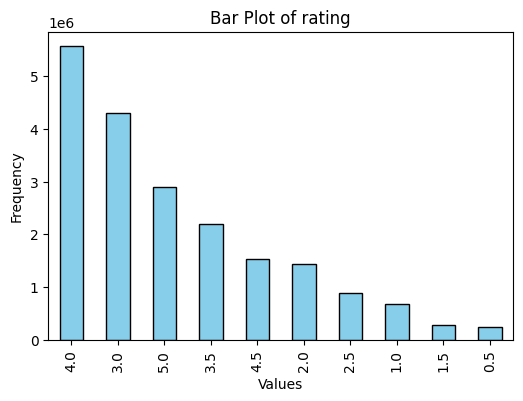

In [20]:
# Create a bar plot for the 'rating' values
rating['rating'].value_counts().plot(kind='bar', figsize=(6, 4), color='skyblue', edgecolor='black')
plt.title('Bar Plot of rating')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

Before we proceed, we want to check if the user Ids appearing in ```tag``` are a subset of the user Ids appearing in ```rating```. Moreover, it would be useful to verify if the unique (```userId```, ```movieId```) pairs from ```tag``` are contained in those from ```rating```. This will be helpful for the next point.

In [21]:
# Check if the userIds in tag are a subset of userIds in 'rating'
tag_user_ids = set(tag['userId'])
rating_user_ids = set(rating['userId'])
# Verify if all userIds in 'tag' are in 'rating'
is_subset_user_ids = tag_user_ids.issubset(rating_user_ids)
print(f"All userId's in 'tag' are a subset of those in 'rating': {is_subset_user_ids}")

# Check if the unique (userId, movieId) pairs in 'tag' are in 'rating'
tag_user_movie_pairs = set(zip(tag['userId'], tag['movieId']))
rating_user_movie_pairs = set(zip(rating['userId'], rating['movieId']))

# Verify if all (userId, movieId) pairs in 'tag' are in 'rating'
are_tag_pairs_in_rating = tag_user_movie_pairs.issubset(rating_user_movie_pairs)
print(f"All (userId, movieId) pairs in 'tag' are contained in 'rating': {are_tag_pairs_in_rating}")

All userId's in 'tag' are a subset of those in 'rating': True
All (userId, movieId) pairs in 'tag' are contained in 'rating': False


This result shows us that we can access all user Ids in the ```rating``` table. However, not all the movies every user has seen are in that table, because from the outputs above it appears that some users created tags for a movie without rating it. On the other hand, users can also rate a movie without creating tags for it. Therefore, when we want to get all the movies that a user has watched, we have to consider both ```rating``` and ```tag```.

To make things easier, we can create another DataFrame where we store all unique (```userId```, ```movieId```) pairs appearing in the two tables.

In [22]:
# Create a set without duplicates of the (userId, movieId) pairs
user_movie_pairs = tag_user_movie_pairs.union(rating_user_movie_pairs)
# Create a DataFrame of unique userId, movieId pairs
user_movie_df = pd.DataFrame(user_movie_pairs, columns = ['userId','movieId'])
# Sort the dataframe by 'userId'
user_movie_df.sort_values(by='userId',inplace=True)
user_movie_df

,userId,movieId
7290619,1,2118
13122072,1,5797
19316690,1,8636
15770763,1,1193
8001741,1,4306
...,...,...
11645165,138493,4681
11115816,138493,7090
17908960,138493,4014
689939,138493,4007


## 1.2 Minhash Signatures

The purpose of minhash is to compare users with similar movie watching habits. Each user is associated with a set of movies, so we could just use the Jaccard similarity between sets of watched movies to compare users. However, for very large sets this is expensive, so we want to compress the information of a user's watched movies into a smaller array, called signature vector. When we later compare user information in the form of signature vectors, we want corresponding elements of two signature vectors (two users) to be equal with probability the Jaccard similarity between the associated users, to have a good representation of the user's original movie sets.

Signature vectors are created in the following way:

1. We collect all unique movie IDs which make up the sets of watched movies of the users, and use the movie IDs as shingles (atomic elements of the universal set of items, in our case, movie IDs)
2. In theory, we imagine having a matrix where columns are associated with user IDs and rows are associated with movie IDs, and the matrix's elements are 1 whenever the column user has seen the row's movie.
3. Still in theory, we imagine shuffling the matrix rows, and now see for each user ID (column) what the row index is of the first row that contains a 1 in their column (the first movie they watched in the new movie order created by the shuffling). We put this row index into the signature vector of the corresponding user, and repeat this for every user ID, always taking the row index with the first 1. Now we have one value in the signature vector of each user. To better represent users, we repeat this procedure of shuffling the starting matrix k times in total, and always add to the signature vectors the minimum row index containing a 1, for each user ID column.
5. In practice, shuffling the rows of a large matrix is expensive, so we use another way to permute row indeces. We hash the row indeces with functions that gives us an approximately uniform distribution over the range of rows (number of shingles/ movie IDs). If the number of collisions is not too large, it will not influence the outcome too much. After hashing row indeces, for each user we take the minimum hash value among the hashed row indeces of the movies they watched.

To do this, we first associate an initial virtual row index to each movie ID, from 0 to (#movies-1), and create a dictionary ```user_movies_dict``` where the keys are user IDs and the values are the row indeces of the movies they watched.

To hash the movie ID row indeces, we use two types of hash functions, both implemented in the ```hash.py``` module:
1. **linear_hash**: given ```a```, ```b```, ```p``` (prime larger than number of movies) and the positive integer ```x``` to hash, the function ```linear_hash``` returns ```(a*x + b) % p```
2. **bitwise_hash**: given ```a```, ```b```,  ```p``` (prime larger than number of movies) and the positive integer ```x``` to hash, the function ```bitwise_hash``` takes the XOR of each element with ```a```, adds ```b``` to the this, and returns the modulo of the result with respect to ```p```.
Both these hash functions generate few collisions between different elements and we use ```numpy``` arrays to vectorize operations and accelarate computations.

We create two **minhash** functions that leverage the hash functions above:
1. The first one, ```random_minhash```, takes as input an array of user IDs, ```user_ids```, the dictionary ```user_movies_dict```, the length of the signature vectors ```k```, the prime number ```p```, and a ```seed``` for the random number generator inside of it. For every iteration from 0 to k-1, ```random_minhash``` randomly chooses between the two above defined hash functions and randomly generates their parameters. That random hash function is then used to hash the virtual row indeces of the shingles (movie IDs), and for each user we take $\min_{\text{movieId } \in \text{ watchedMovies}}(hash(rowIndex( \text{ movieId })))$ where $watchedMovies$ here indicates the set of movies watched by the user.
2. The second one, ```minhash```, allows the user to choose which hash functions (among the two above) to use, and with which parameters. It takes as input the array ```user_ids```, the dictionary ```user_movies_dict```, the length of the signature vectors ```k```, as well as information about the hash functions to use. ```minhash``` does not pick hash functions at random, but recieves in input also a binary vector ```k_hash_function_choices```, where element ```i``` is ```0``` if the i-th hash function chosen *outside* the minhash is the ```linear_hash```, while element ```i``` of ```k_hash_function_choices``` is ```1``` if the i-th hash function chosen is ```bitwise_hash```. The other two input variables are dictionaries ```linear_parameters``` and ```bitwise_parameters```, that for key ```i```, if it exists, contain the chosen parameters of the associated hash functions.

So the main difference between ```random_minhash``` and ```minhash``` is that the first one picks hash functions randomly, while for the second one the hash functions to use (and their parameters) are established on the outside and passed as input to the function.

To start, we create the numpy arrays ```user_ids``` and ```movie_ids``` of unique user ID and movie ID values. Then we create a dictionary associating each element in ```movie_ids``` (shingle) to a unique integer in ```range(0,len(movie_ids))```, to have virtual row indeces for the movie IDs. These are the values we are going to hash.

In [23]:
# Create numpy arrays to store movie IDs and user IDs
user_ids = np.array(user_movie_df.userId.drop_duplicates())
movie_ids = np.array(user_movie_df.movieId.drop_duplicates())

# Print the min and max MovieId values and the number of MovieId values to know the shingle range
num_movies = len(movie_ids)
print('\nNumber movieIds = ', num_movies)

# Create a dictionary that maps movie_ids values to virtual row indeces
movie_ids_dict = dict({movie_ids[i]:i for i in range(num_movies)})


Number movieIds =  27278


We see that the number of movie IDs is 27'278. It is possible to verify that the first prime number after 27'278 is 27'281, so we will use this for modulo hashing later.

To implement the ```user_movies_dict``` dictionary, as anticipated above, we are going to:
1. Build a simple function ```movie_to_row``` that maps movie IDs to their row index as defined in ```movie_ids_dict```
2. Take the previously defined ```user_movie_df``` DataFrame (containing (userId, movieId) pairs of all the movies individual users have watched), and add a new column ```movie_row``` to it, which is the result of applying the function ```movie_to_row``` to the ```movieId``` column
3. Group ```user_movie_df``` by ```userId```, select the column ```movie_row```, apply the ```np.array``` function group-wise
4. Turn the result into a dictionary

The outcome of this procedure is a dictionary ```user_movies_dict```, where the keys are user IDs and their values are numpy arrays containing the virtual row indeces of the movie IDs from their watched movies.

In [24]:
# Function that maps movie_ids their corresponding value in movie_ids_dict
def movie_to_row(movie_id, movie_ids_dict):
    '''
    Function that maps movie IDs to their virtual row index in movie_ids_dict
    Inputs:
    - movie_id (int): movie ID
    - movie_ids_dict (dict): dictionary that maps movie IDs to virtual row indeces
    Output:
    - int: row index of the associated movie ID
    '''
    try:
        return movie_ids_dict[movie_id] # return this if the movie ID is in the dictionary
    except:
        print('Movie ID not in dictionary') # print this if the movie ID is not in the dictionary

# Add a column to 'user_movies_df' of the row indeces associated with the movieIds
# In other words, create a new column 'movie_row' which is the result of applying
# movie_to_row to the 'movieId' column
user_movie_df['movie_row'] = user_movie_df['movieId'].apply(lambda x: movie_to_row(x, movie_ids_dict))

# Group by 'userId' and aggregate watched movie IDs into numpy arrays for each user
user_movies_dict = user_movie_df.groupby('userId')['movie_row'].apply(np.array).to_dict()

Before using the minhash functions, let us verify if ```linear_hash``` and ```bitwise_hash``` indeed distribute the integer row indeces to hash in a uniform way. We will plot histograms of both functions (with some manually selected default parameters) applied to the virtual row indeces, and hope that the histograms are approximately uniform.

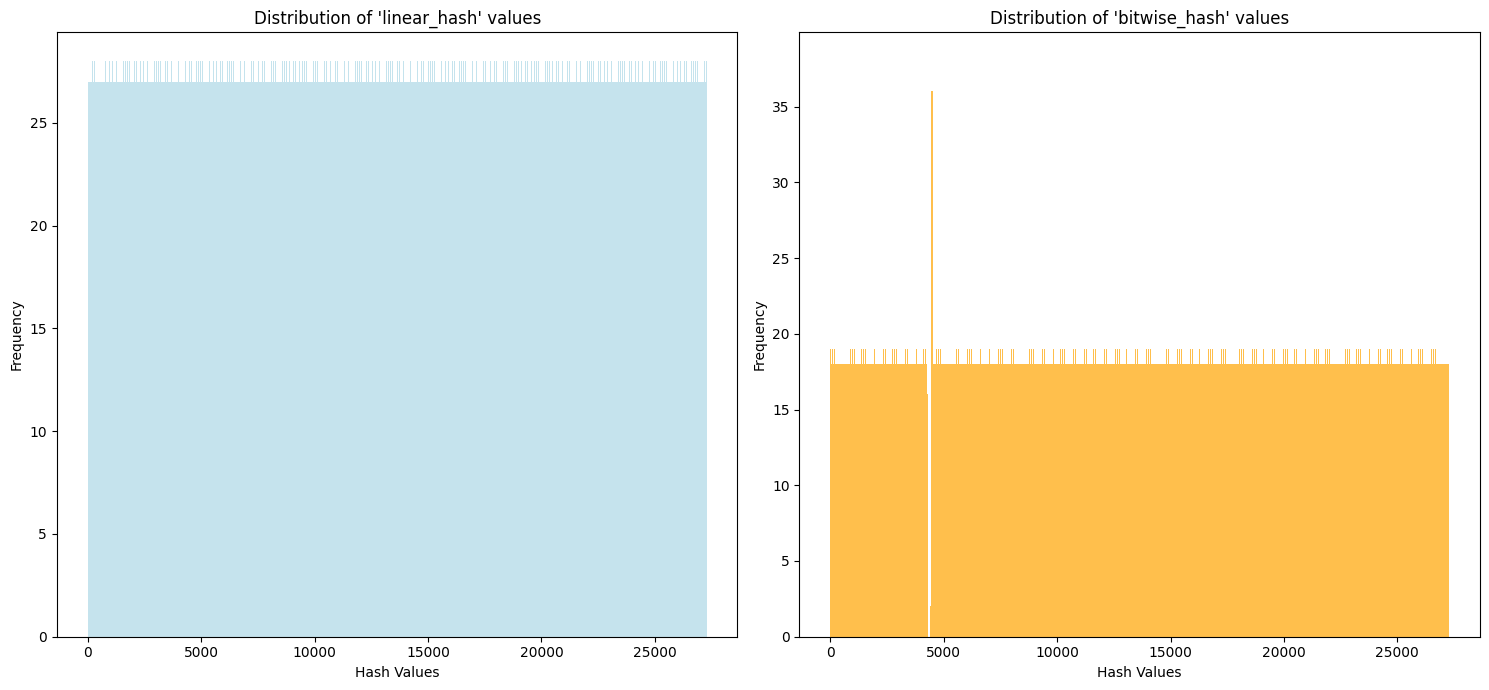

In [ ]:
# Virtual row indeces array
row_indeces = np.array(range(num_movies))

linear_results = linear_hash(row_indeces) # hash row_indeces with linear_hash
bitwise_results = bitwise_hash(row_indeces) # hash row_indeces with bitwise_hash

fig, axes = plt.subplots(1,2,figsize=(15,7))

# Distribution of linear_hash over row_indeces
axes[0].hist(linear_results, bins=1000, color='lightblue', alpha=0.7)
axes[0].set_xlabel('Hash Values')
axes[0].set_ylabel('Frequency')
axes[0].set_title("Distribution of 'linear_hash' values")

# Distribution of bitwise_hash over row_indeces
axes[1].hist(bitwise_results, bins=1500, color='orange', alpha=0.7)
axes[1].set_xlabel('Hash Values')
axes[1].set_ylabel('Frequency')
axes[1].set_title("Distribution of 'bitwise_hash' values")

plt.tight_layout()
plt.show()

We see that the distribution of the ```linear_hash``` values is sufficiently uniform, and that of the ```bitwise_hash``` values is also mostly uniform, except for some more collisions around the value of ```b```, in this case 4435. This is likely due to the fact that the additive shift causes some values to concentrate more around ```b```. We can address this issue by randomizing the choice of ```b```. The ```random_minhash``` function does exactly that. Since the ```linear_hash``` and ```bitwise_hash``` generate a mostly uniform distribution over the range of virtual row indeces, we can try using both.

Below we can see the signature matrix that originates from using ```random_minhash``` for generating signature vectors of length k=100. As a reminder, ```random_minhash``` picks k random hash functions between the two implemented options, generates random parameters for them, and uses these hash functions to create the signature vectors.

In [ ]:
# Calculate the signature matrix of the users with k=50 using the random_minhash function
k = 50
signature_matrix, hash_functions = random_minhash(user_ids, user_movies_dict, k)

# Display first 20 rows of the signature matrix
random_minhash_output = pd.DataFrame(signature_matrix, columns = user_ids)
print('First 20 rows of the signature matrix for k=50:')
display(random_minhash_output.iloc[:20]) # display random_minhash_output

First 20 rows of the signature matrix for k=50:


,1,2,3,4,5,6,7,8,9,10,...,138484,138485,138486,138487,138488,138489,138490,138491,138492,138493
0,21024,21024,20768,20808,20770,20809,20768,20770,20787,20787,...,14300,19072,866,16079,20103,18769,142,19069,13923,883
1,62,73,73,826,466,4940,73,297,859,1410,...,297,253,62,106,1792,521,248,778,881,172
2,18781,18840,18782,18785,18785,18891,18269,18287,18276,18309,...,15073,18269,8961,6402,18341,18292,10202,18283,14536,10438
3,1023,722,34,1668,421,464,421,335,1708,679,...,335,1109,74,68,1923,2559,114,249,526,74
4,4203,4204,4075,3957,3947,3954,3819,3691,3707,3703,...,3691,3436,1923,3699,3470,3521,3481,3440,3440,3438
5,10018,10025,9782,9762,9762,9780,9764,9762,9802,9802,...,6885,8054,6780,6794,9086,7724,6700,8070,6901,6717
6,25,134,134,570,2,570,111,25,88,243,...,2,1396,134,914,2,1224,76,1029,415,2
7,292,172,52,546,359,359,119,493,1107,3376,...,147,172,200,599,2815,1640,295,1308,239,200
8,9615,9559,9551,9564,9562,9562,9167,9135,9105,9103,...,7115,7490,7158,7202,9141,7104,7212,7505,7085,7149
9,1065,1049,1056,1133,1057,1097,665,572,553,561,...,572,644,538,540,588,538,37,540,208,237


Now we want to see if the original goal - representing the user ID watched-movie-sets with signature vectors - is fulfilled. For this, we will sample ```N``` random users (```N``` can also be the total number of users), split them into two groups of size ```N/2```, and compare ```N/2``` pairs of users between the two groups by computing their Jaccard similarity. Then, we compare their signature vectors, and see if the following condition holds:

Let $s_1$ and $s_2$ be the signature vectors of some ```user1``` and ```user2```. For a random index $i=1,\cdots,k$ in the signature vector:

$\mathbf{P}(s_1[i]=s_2[i]) = jaccardSimilarity(user1,user2)$

To compute that probability, we use a frequentist approach. We find the number of all the rows in which the two signature vectors coincide, then divide it by the total number of rows. Then, we see if that is approximately equal to the jaccard similarity between the associated users.

Mean Absolute Error: 0.024583090401754132


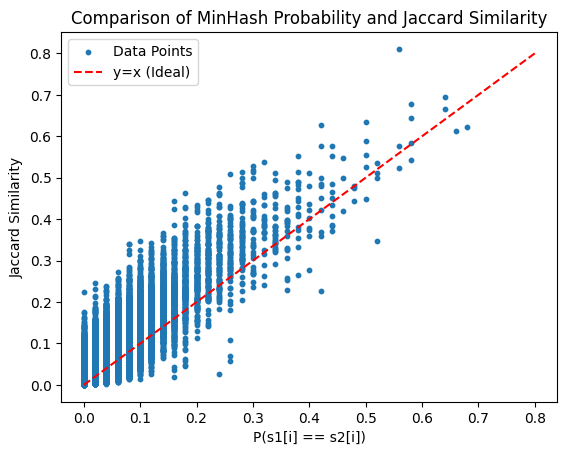

In [ ]:
N = len(user_ids) # number of users to compare
# List of all user columns
all_user_columns = list(range(signature_matrix.shape[1]))
# Sampled user columns
sampled_user_columns = random.sample(all_user_columns, N)
# Split the sampled users into two groups
first_group = sampled_user_columns[:(N//2)]
second_group = sampled_user_columns[(N//2):]

errors = [] # Initialize list to store errors, the abs differences between P(s1[i]=s2[i]) and Jaccard(user1, user2)
prob_values = [] # Initialize list to store probability values P(s1[i]=s2[i]) as defined above
jaccard_values = [] # Initialize list to store Jaccard similarity values between pairs of users

# Pair-wise compare jaccard similarity of the users with their
# probability of having corresponding signature vector elements
for i in range(N//2):

    # Signature vectors of the current pair of users
    signature1 = signature_matrix[:,first_group[i]]
    signature2 = signature_matrix[:,second_group[i]]
    # Compare signature vectors
    prob_same_el = sum(signature1==signature2)/k
    prob_values.append(prob_same_el) # add probability to prob_values list

    # User ID of the current user
    user1 = user_ids[first_group[i]]
    user2 = user_ids[second_group[i]]
    # Sets of watched movies of the users (actually the virtual movie rows, but the result is the same)
    watched_movies1 = set(user_movies_dict[user1])
    watched_movies2 = set(user_movies_dict[user2])
    # Jaccard similarity of the users
    jaccard_sim = jaccard_similarity(watched_movies1, watched_movies2)
    jaccard_values.append(jaccard_sim) # add jaccard similarity to the list

    # Calculate error
    errors.append(abs(prob_same_el - jaccard_sim))

    # Print results
    #print(f"P(s1[i]==s2[i]) = {prob_same_el}, Jaccard(user1, user2) = {jaccard_sim}")

# Print the average absolute error
print(f"Mean Absolute Error: {np.mean(errors)}")

# Print scatter plot to compare minhash probability and jaccard similarity scores
plt.scatter(prob_values, jaccard_values, s=10, label='Data Points')
plt.plot([0, 0.8], [0, 0.8], color='red', linestyle='--', label='y=x (Ideal)')
plt.xlabel("P(s1[i] == s2[i])")
plt.ylabel("Jaccard Similarity")
plt.legend()
plt.title("Comparison of MinHash Probability and Jaccard Similarity")
plt.show()


This result is not bad. For signature vectors of length ```k=50```, and picking random hash functions with ```seed=198324``` in ```random_minhash```, we get an average error between MinHash Probability and Jaccard similarity (from random pairs of users) of about 2.47%. This means that on average, the minhash method approximates the original user similarities very well. The scatter plot shows us that the data points (MinHashProbability, JaccardSimilarity) are mostly concentrated around the $y=x$ line. Errors are primarily below 0.2, but we can try to see if the results can be improved.

To perform some experiments, we implemented the functions ```random_minhash_results``` and ```minhash_results```.

* ```random_minhash_results```: takes the same inputs as ```random_minhash``` and returns the average error rate of a sample of ```N=10000``` (comparing 5000 random user pairs). We are going to use this function multiple times, each time with different parameters ```k``` and ```seed```, and remember which random hash functions and parameters were chosen for given values of ```k``` and ```seed```.
* ```minhash_results```: takes the same inputs as ```minhash``` and returns the average error rate of a sample of ```N=10000``` (comparing 5000 random user pairs). Unlike before, this function allows for more control over the choice of hash functions and parameters.

By using ```random_minhash_results``` and ```minhash_results``` we can compare different configurations by their error rates, both with random choices and controlled selections of hash functions. In the end, we will keep the configuration that minimizes the average error rate.

**Observation**: it does not matter in what order we apply a set of k hash functions. The resulting signature vectors will just have permuted rows, but it will not influence the overall similarity between them. This is because we always hash the same values (virtual row indeces of movie IDs) and hash functions are independent among each other.

#### Experiment

**First Case (with ```minhash```)**: use only the ```linear_hash``` function
* Test different values of ```k```, from the list ```[50, 100, 200, 250]```
* Choose ```a``` and ```b``` by sampling ```k``` different integers from ```[1,p]``` for each parameter (fixed seed here), with ```p=27281```. Try 5 different values of ```a``` with 5 different values of ```b```.

**Second Case (with ```minhash```)**: use only the ```bitwise_hash``` function
* Test different values of ```k``` from the list ```[50, 100, 200, 250]```
* Choose ```a``` and ```b``` by sampling ```k``` different integers from ```[1,p]``` for each parameter (fixed seed here), with ```p=27281```. Try 5 different values of ```a``` with 5 different values of ```b```.

**Third Case (with ```random_minhash```)**: use both ```linear_hash``` and ```bitwise_hash```
* Test different values of ```k``` from the list ```[50, 100, 200, 250]```
* Test different values of ```seed``` to get different random outputs
* Randomize the choice of hash function and let ```random_minhash``` tell you which parameters and functions it chose

We are going to compare all the results and keep the configuration that gives us the lowest error rate.

In [ ]:
p = 27281
k_values = [50, 100, 150, 200, 250] # list of values to pick k from
seeds = [0, 42, 999, 12345, 4294967295]
a_b_range = list(range(1,p))

results = [] # Initialize list of tuples that will contain the results

min_error1 = 1
best_param1 = None

min_error2 = 1
best_param2 = None

min_error3 = 1
best_configuration3 = None

# Iterate over k_values
for k in tqdm(k_values):

    random.seed(12345) # seed for choosing parameters 'a' and 'b'

    # First Case & Second Case
    for _ in tqdm(range(5)):
        parameter_values = random.sample(a_b_range, 2*k)
        a_values, b_values = parameter_values[:k], parameter_values[k:]
        parameters = {i:(a_values[i], b_values[i]) for i in range(k)}
        #print(parameters)

        # First Case
        k_hash_function_choices1 = np.zeros(k)
        errors1 = minhash_results(user_ids, user_movies_dict, k_hash_function_choices1, linear_parameters=parameters, k=k)
        avg_error1 = np.mean(errors1)
        results.append((k, 'linear_hash', 12345, avg_error1))
        if avg_error1 < min_error1:
            min_error1 = avg_error1
            best_param1 = {'a':a_values, 'b':b_values}

        # Second Case
        k_hash_function_choices2 = np.ones(k)
        errors2 = minhash_results(user_ids, user_movies_dict, k_hash_function_choices2, bitwise_parameters=parameters, k=k)
        avg_error2 = np.mean(errors2)
        results.append((k, 'bitwise_hash', 12345, avg_error2))
        if avg_error2 < min_error2:
            min_error2 = avg_error2
            best_param2 = {'a':a_values, 'b':b_values}

    # Third Case
    for seed in tqdm(seeds):
        errors3, hash_functions = random_minhash_results(user_ids, user_movies_dict, k=k, seed=seed)
        avg_error3 = np.mean(errors3)
        results.append((k, 'both', seed, avg_error3))
        if avg_error3 < min_error3:
            min_error3 = avg_error3
            best_configuration3 = hash_functions

results_df = pd.DataFrame(results, columns = ['k', 'hashFunction', 'seed', 'avg_error'])

# Print results
print('Best Performance with only linear_hash: ', min_error1)
print('Best Performance with only bitwise_hash: ', min_error2)
print('Best Performance with both hash functions: ', min_error3)
print('\nAll results')
display(results_df)

100%|██████████| 5/5 [02:47<00:00, 33.46s/it]

100%|██████████| 5/5 [02:48<00:00, 33.78s/it]

100%|██████████| 5/5 [02:48<00:00, 33.65s/it]

100%|██████████| 5/5 [02:48<00:00, 33.79s/it]

100%|██████████| 5/5 [02:47<00:00, 33.59s/it]

100%|██████████| 5/5 [1:58:43<00:00, 1424.70s/it]

Best Performance with only linear_hash:  0.03455867070411754
Best Performance with only bitwise_hash:  0.0413611341469248
Best Performance with both hash functions:  0.015094881170205774

All results


,k,hashFunction,seed,avg_error
0,50,linear_hash,12345,0.039036
1,50,bitwise_hash,12345,0.046125
2,50,linear_hash,12345,0.035866
3,50,bitwise_hash,12345,0.043359
4,50,linear_hash,12345,0.037731
...,...,...,...,...
70,250,both,0,0.016990
71,250,both,42,0.018583
72,250,both,999,0.017464
73,250,both,12345,0.017890


Best configuration hash functions: 
The first element of a tuple indicates if it is linear_hash (0) or bitwise_hash (1)
The second and third element are the respective function parameters that we called a and b in both cases.
[(1, 15403, 9308), (0, 130, 5987), (0, 18364, 5181), (1, 12422, 20491), (0, 9751, 13804), (0, 3812, 20874), (0, 24263, 26230), (0, 14933, 2094), (1, 25272, 9287), (0, 4318, 8671), (1, 20475, 16503), (1, 3131, 15184), (0, 26265, 24979), (1, 23293, 25130), (1, 17026, 11915), (0, 11296, 7818), (1, 26404, 1222), (1, 4031, 22179), (0, 12562, 7210), (1, 23757, 20641), (1, 23560, 9114), (0, 15452, 21608), (0, 658, 19998), (1, 10423, 19967), (1, 18144, 9674), (1, 25859, 458), (1, 17217, 14133), (0, 15217, 27234), (0, 18514, 21910), (0, 11563, 16987), (1, 20017, 21447), (0, 19725, 10252), (0, 19393, 11844), (1, 22578, 24769), (0, 15240, 23109), (0, 3445, 9778), (0, 16768, 25832), (1, 5157, 12319), (1, 2442, 26064), (0, 16254, 16034), (1, 13938, 17244), (1, 907, 21770), (1,

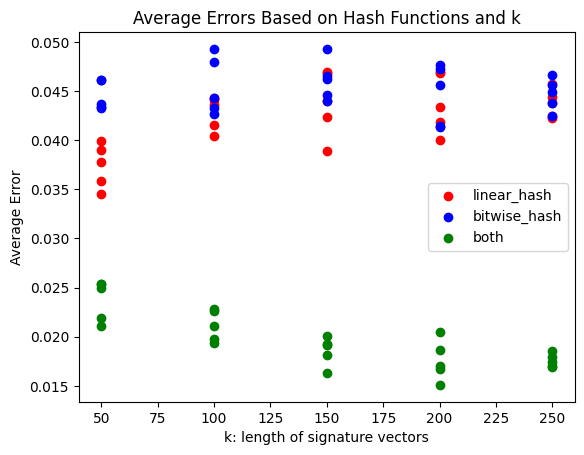

In [ ]:
# Let us safe the results table in a csv file
results = results_df.to_csv()

# Print parameters
print('Best configuration hash functions: ')
print('The first element of a tuple indicates if it is linear_hash (0) or bitwise_hash (1)')
print('The second and third element are the respective function parameters that we called a and b in both cases.')
print(best_configuration3)

# Make dataframes for specific functions
linear_results_df = results_df[results_df['hashFunction']=='linear_hash']
bitwise_results_df = results_df[results_df['hashFunction']=='bitwise_hash']
both_results_df = results_df[results_df['hashFunction']=='both']

# Create the scatter plots
plt.scatter(linear_results_df['k'], linear_results_df['avg_error'], color='red', label='linear_hash')
plt.scatter(bitwise_results_df['k'], bitwise_results_df['avg_error'], color='blue', label='bitwise_hash')
plt.scatter(both_results_df['k'], both_results_df['avg_error'], color='green', label='both')
plt.xlabel('k: length of signature vectors')
plt.ylabel('Average Error')
plt.title('Average Errors Based on Hash Functions and k')
plt.legend()
plt.show()


From the scatter plot, we see that on average we get the best results by combining both ```linear_hash``` and ```bitwise_hash```, and slightly worse results by using only one of them. This can likely be explained by the fact that there is a broader choice of hash functions for ```random_minhash``` and on average more uniform simulated permutations, which can lead to better comparison between MinHash probability and Jaccard Similarity.

The best configuration was achieved by taking ```k=200```, ```seed=4294967295``` as input to ```random_minhash```.  These gave us an average error rate of about 1.5%, so an accuracy of around 98.5%. Here are the parameters of the best found scenario in detail:

In [ ]:
# Print best configuration
print("Best configuration:")
display(results_df[results_df['avg_error']==0.015094881170205774])

# Function that returns 'linear_hash' if input is 0, 'bitwise_hash' otherwise (if it is 1)
num_to_function = lambda x: 'linear_hash' if x==0 else 'bitwise_hash'

# Print the hash functions for the best configuration
best_configuration = pd.DataFrame(best_configuration3.copy(), columns = ['function', 'a', 'b'])
best_configuration['function'] = best_configuration['function'].apply(num_to_function)
display(best_configuration)

Best configuration:


,k,hashFunction,seed,avg_error
59,200,both,4294967295,0.015095


,function,a,b
0,bitwise_hash,15403,9308
1,linear_hash,130,5987
2,linear_hash,18364,5181
3,bitwise_hash,12422,20491
4,linear_hash,9751,13804
...,...,...,...
195,linear_hash,10386,5668
196,linear_hash,6359,26171
197,bitwise_hash,2042,7590
198,linear_hash,14567,18161


We will now take the functions and parameters from the best result, and plot the signature matrix of the user IDs using the configuration found above.

In [25]:
# Define best configuration variables and parameters to pass to the minhash function
k= 200
seed=4294967295
signature_matrix, hash_funcs = random_minhash(user_ids, user_movies_dict, k, seed=seed)
# Display first 20 rows of the signature matrix
best_config_output = pd.DataFrame(signature_matrix, columns = user_ids)
print('First 20 rows of the signature matrix:')
display(best_config_output.iloc[:20]) # display minhash_output

First 20 rows of the signature matrix:


,1,2,3,4,5,6,7,8,9,10,...,138484,138485,138486,138487,138488,138489,138490,138491,138492,138493
0,24668,24671,24669,24728,24668,24677,24671,24683,24714,24717,...,18477,22623,10720,13333,23693,22636,13852,22671,19543,13529
1,26,1196,26,45,695,1456,64,45,305,305,...,45,771,26,996,1215,1012,400,1012,270,45
2,67,253,2,95,95,1155,95,30,718,67,...,30,1927,30,207,30,430,170,504,207,2
3,5498,5504,5498,5578,5499,5539,5503,5521,5508,5537,...,1506,5558,1589,849,5578,5519,190,5571,2405,586
4,218,1526,99,1080,872,1516,89,525,1090,317,...,376,307,69,187,525,178,89,2655,277,58
5,23,253,209,72,899,302,28,72,2279,1452,...,72,904,23,1022,5264,620,586,904,1888,146
6,20,1329,96,810,734,1524,53,810,453,215,...,0,20,20,185,1286,86,489,638,377,3
7,86,132,155,1609,178,178,178,478,247,824,...,109,15,616,776,478,86,62,1470,501,37
8,7110,7094,7102,7204,7101,7117,6710,6622,6598,6599,...,6622,6633,223,2463,6634,6735,119,6706,6625,199
9,55,453,75,1070,95,274,75,433,254,831,...,76,2980,55,294,433,433,76,75,274,17


## 1.3 Locality-Sensitive Hashing (LSH)

### Creating Buckets

Comparing users to find similarities between them for recommendation purposes is still an expensive task despite having compressed information about user watching habits into signature vectors. Therefore, we will use the LSH algorithm to hash bands (sub-arrays) of the signature vectors into buckets. If two users are in the same bucket, it is more likely that they share a higher similarity. So instead of comparing a user with every other user, we just compare it with the users in the same bucket(s), the set of *candidates*.

Our implementation of the LSH involves:
* **Band Size**: We pick a band size ```r``` that is a divisor of ```k=200``` (length of the signature vectors). Choosing the band size ```r``` is equivalent to choosing the number of bands ```b```. A measure that follows directly from the choice of these parameters is the *threshold*, which indicates the jaccard similarity two users must have such that their probability of ending in the same bucket is $1/2$. For band size ```r``` and number of bands ```b```, the threshold is approximately equal to $(1/b)^{1/r}$. The higher we pick ```r```, the more we increase the threshold, because each band contains more rows, so two users must agree on more rows within a single band to hash into the same bucket. This makes it harder for less similar users to become candidates. If we decrease ```r```, the opposite happens, and it becomes more likely that two users are hashed into the same bucket.
* **Hashing**: We use a linear hash function ```linear_dot_prod_hash``` that hashes arrays to the range ```[1,p]```, where ```p``` is a large prime indicating the total number of possible buckets. We want to pick ```p``` sufficiently high such that collisions are minimized, but not so high that users are too sparsely distributed in the buckets. We could randomize the choice of hash function parameters by setting a certain starting ```seed```.
* **Trials and Debugging**: We will begin with some initial choice of parameters ```r```, ```p```, ```seed``` and see if multiple users land in the same buckets (bucket population is not too sparse). We will also evaluate the performance of the LSH algorithm based on whether more similar users are hashed to the same buckets, and based on the average candidate set size for users. After this initial trial, we will test some more values for ```r```, ```p```, ```seed```, and repeat performance evaluation. For the recommendation system, we will keep the combination of ```r```, ```p```, ```seed``` that best balances the trade-off between minimizing average size of candidate set and maximizing the percentage of similar users hashed to the same bucket. Because the ultimate goal is to have similar users already grouped together, and minimizing the number of comparisons we need to compute.

To start, we can choose ```r=5```, ```p=200003``` and ```seed=4294967295```, and hash bands of size ```r``` from each signature vector to buckets in the range ```[1,p]```. We use the ```LSH``` function for this, and in return we will get a dictionary ```buckets``` that maps buckets to the users that were hashed into it, and a dictionary ```candidates``` that maps users to all the potentially similar users (the users they share buckets with).

In [ ]:
r=5
p=200003
seed=4294967295

# Hash bands to buckets
buckets, candidates = LSH(signature_matrix, user_ids, r, p, seed)

# Create dataframe to store the buckets and number of users hashed to each bucket
buckets_df = pd.DataFrame(buckets.items(), columns = ['Bucket', 'Users'])
buckets_df['NumUsers'] = buckets_df['Users'].apply(len)

# Create dataframe to store the users and candidates with potential similarity to them
candidates_df = pd.DataFrame(candidates.items(), columns = ['User', 'Candidates'])
candidates_df['NumCandidates'] = candidates_df['Candidates'].apply(len)

# Print number of buckets
print('Number of buckets: ', len(buckets))

# Print users hashed to each bucket
print('Users hashed to each bucket:')
display(buckets_df)

# Print candidates of each user
print('Candidates of each user:')
display(candidates_df)

Number of buckets:  200003
Users hashed to each bucket:


,Bucket,Users,NumUsers
0,22873,"[1, 6588, 10862, 13886, 36565, 47230, 53692, 6...",19
1,181599,"[1, 4454, 6086, 6155, 9990, 13698, 16408, 1970...",38
2,11733,"[1, 10672, 16346, 18114, 24683, 27683, 32686, ...",36
3,37218,"[1, 2847, 6922, 7564, 8112, 9747, 17104, 24603...",36
4,21818,"[1, 791, 3403, 5080, 6025, 6727, 15957, 19783,...",58
...,...,...,...
199998,104502,"[55903, 62688, 63843, 65397, 72292, 78940, 843...",11
199999,114650,"[56437, 62477, 68037, 70344, 73881, 76763, 857...",19
200000,95408,"[57869, 65268, 69912, 78001, 78734, 107319, 10...",11
200001,119391,"[59451, 62698, 70517, 73380, 99384, 108810, 11...",18


Candidates of each user:


,User,Candidates,NumCandidates
0,1,"{53248, 133122, 81921, 100356, 61448, 124937, ...",1072
1,2,"{86021, 14344, 106505, 133130, 122894, 16405, ...",1034
2,3,"{108545, 8194, 129028, 47108, 122886, 77833, 1...",1010
3,4,"{137216, 28674, 69634, 94212, 63493, 86023, 32...",1166
4,5,"{61441, 81921, 18437, 67591, 106504, 133129, 1...",1118
...,...,...,...
138488,138489,"{73729, 75782, 63494, 122888, 14344, 96267, 26...",1161
138489,138490,"{47104, 18434, 55298, 110598, 135175, 129032, ...",1064
138490,138491,"{137216, 63488, 135170, 4099, 34820, 55300, 71...",1103
138491,138492,"{55297, 43010, 4098, 49161, 63497, 70016, 1065...",1070


The tables displayed above contain detailed information about the buckets and the candidates. We can plot histograms to visualize the distribution of the bucket sizes and and the candidate set sizes.

Average size of candidate set:  1263.347360516416


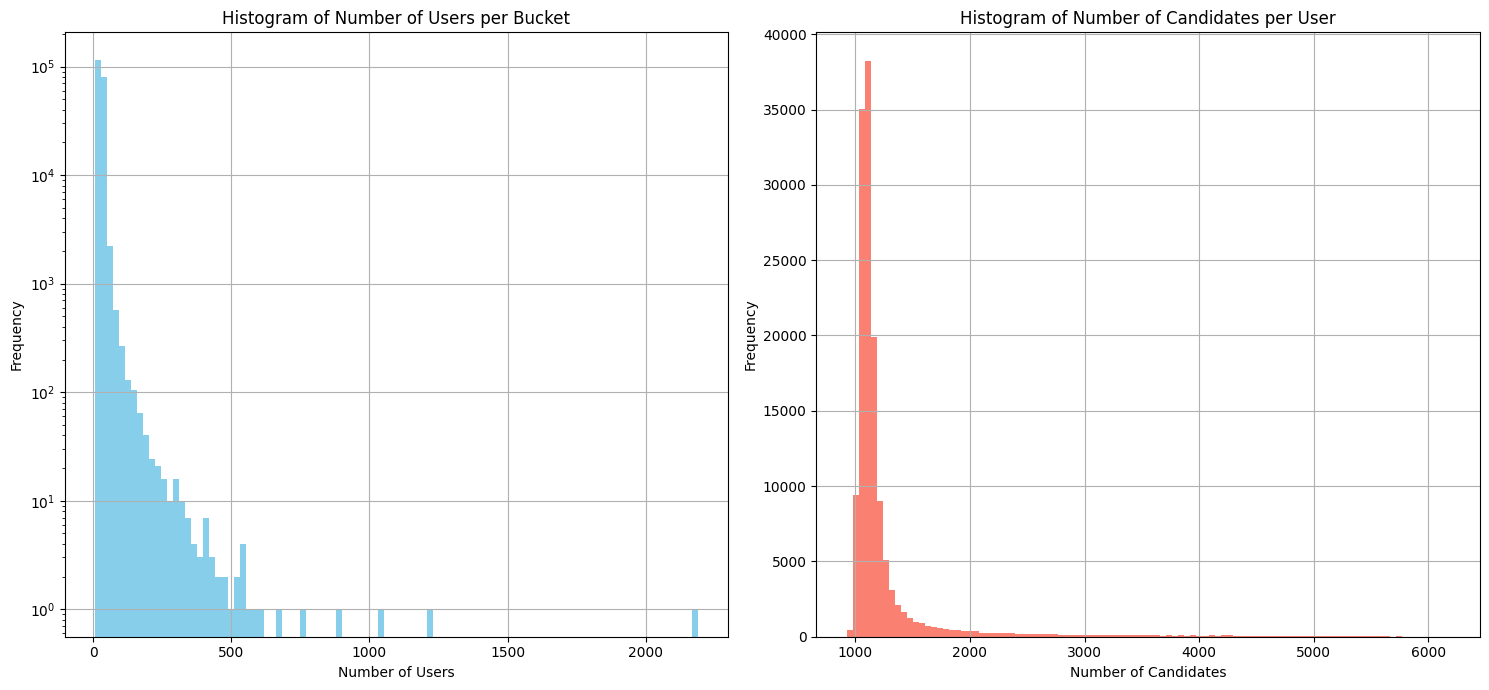

In [ ]:
# Average size of candidate set
print('Average size of candidate set: ', candidates_df['NumCandidates'].mean())

# Plot bucket and candidate number distributions
fig, axes = plt.subplots(1,2,figsize=(15,7))

# Plot histogram of buckets_df['NumUsers']
buckets_df['NumUsers'].hist(ax=axes[0], bins=100, color='skyblue', log=True)
axes[0].set_xlabel('Number of Users')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Number of Users per Bucket')

# Plot histogram of candidates_df['NumCandidates']
candidates_df['NumCandidates'].hist(ax=axes[1], bins=100, color='salmon')
axes[1].set_xlabel('Number of Candidates')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Number of Candidates per User')

plt.tight_layout()
plt.show()

These histograms show us that on average, buckets don't have a very large population, meaning that on average, few users are hashed into the same buckets. However, there are some exceptions. For instance, we can see that some rarer buckets contain hundreds and even over a thousand users hashed into it. Perhaps these buckets contain users that have some very famous watched movies in common, similarities that could have been picked up on by the small band size ```r=5```. The second histograms tells us that the average user shares buckets with around a thousand other users, a number significantly smaller than the total number of users.

Our hope is that the LSH algorithm effectively groups together users that are potentially similar, aiming to avoid false positives (user pairs in the same bucket with low jaccard similarity) and false negatives (user pairs not in the same bucket but with jaccard similarity). What we will do to test the performance of the LSH algorithm, is choose a jaccard similarity value, such as ```0.5```, over which we define users as similar. We will sample a certain number of users from all user IDs (using them all would be very expensive), and calculate the similarity between all pairs of users in this randomly sampled group. If the jaccard similarity of a pair is above ```0.5```, we will add it to a list ```similar_pairs```. Then, we iterate through the pairs and compare them with the ```candidates``` we got from the LSH algorithm.

For a positive performance of the LSH, we want to maximize this quantity: $ (\text{number of similar pairs that are mutual candidates})/(\text{total number of similar pairs}) $

Below we create and display the ```similar_pairs``` with their jaccard similarity scores:

In [27]:
# Find user pairs with jaccard similarity of at least 0.5
jaccard_threshold = 0.5
similar_pairs = [] # Initialize list to store user pairs with jaccard similarity of at least 0.5
random.seed(12345)
user_sample = random.sample(list(user_ids), 5000)

# Iterate over all user pairs
for i in tqdm(range(len(user_sample))):
    for j in range(i+1, len(user_sample)):
        # Compute jaccard similarity between the two users
        jaccard_sim = jaccard_similarity(set(user_movies_dict[user_sample[i]]), set(user_movies_dict[user_sample[j]]))
        if jaccard_sim >= jaccard_threshold: # if jaccard similarity is at least 0.5
            similar_pairs.append((user_sample[i], user_sample[j],jaccard_sim)) # add the pair to the list

# Create a dataframe from the list of tuples
similar_pairs_df = pd.DataFrame(similar_pairs, columns = ['userId1', 'userId2', 'jaccard_sim'])

# Print number of user pairs with jaccard similarity of at least 0.5
print('Number of user pairs with jaccard similarity of at least 0.5: ', len(similar_pairs))
display(similar_pairs_df)

100%|██████████| 5000/5000 [08:32<00:00,  9.76it/s] 


Number of user pairs with jaccard similarity of at least 0.5:  7190


,userId1,userId2,jaccard_sim
0,42386,60899,0.505747
1,42386,60061,0.556962
2,42386,135447,0.625000
3,42386,2923,0.582090
4,42386,68377,0.648649
...,...,...,...
7185,83589,49021,0.637450
7186,25173,112022,0.575758
7187,85979,72275,0.558442
7188,87841,5211,0.642857


Now we will see how many of these the LSH hashed to the same buckets:

In [ ]:
# Initialize list of similar user pairs that are mutual candidates
similar_candidates = []

# Iterate over user pairs with jaccard similarity of at least 0.5
for i in tqdm(range(len(similar_pairs))):
    # If user1 is a candidate of user2 and user2 is a candidate of user1
    if similar_pairs[i][0] in candidates[similar_pairs[i][1]] and similar_pairs[i][1] in candidates[similar_pairs[i][0]]:
        similar_candidates.append(similar_pairs[i]) # add the pair to the list

# Print percentage of similar users that are mutual candidates
print('Percentage of similar users that are mutual candidates: ', len(similar_candidates)/len(similar_pairs))

100%|██████████| 7190/7190 [00:00<00:00, 615927.57it/s]

Percentage of similar users that are mutual candidates:  0.6442280945757998


We see that the percentage of similar users that were hashed together is about 64%, which is already positive. We could try experimenting with different values of ```r```, ```p```, and ```seed```, and see how their performances compare in terms of average candidate set size and percentage of users that are mutual candidates. To make this experiment easier, we made a function that takes the same inputs as the LSH algorithm, and gives us directly the performance evaluation measures ```avg_candidate_set_size``` and ```percentage_similar_candidates```.

In [ ]:
r_values = [5,8,10] # Initialize list of band values
p_values = [138497,250007,300007] # Initialize list of values for the large prime p
seed_values = [999, 12345, 4294967295] # Initialize seed values

LSH_results = [] # Initialize list to store results

# Iterate over band sizes r
for r in tqdm(r_values):
    # Iterate over prime values p
    for p in tqdm(p_values):
        # Iterate over seed values
        for seed in tqdm(seed_values):
            # Evaluate LSH performance
            avg_candidate_set_size, percentage_similar_candidates = LSH_performance(signature_matrix, user_ids, similar_pairs, r, p, seed)
            # Add information to results
            LSH_results.append((r, p, seed, avg_candidate_set_size, percentage_similar_candidates))

# Create results dataframe
LSH_results_df = pd.DataFrame(LSH_results, columns = ['r', 'p', 'seed', 'avg_candidate_set_size', 'percentage_similar_candidates'])

# Print results
print('Minimum average size of candidate set: ', min(LSH_results_df['avg_candidate_set_size']))
print('Maximum percentage of similar users that are candidates: ', max(LSH_results_df['percentage_similar_candidates']))
display(LSH_results_df)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Computed LSH, now evaluating performance




 33%|███▎      | 1/3 [04:04<08:08, 244.33s/it]

Computed LSH, now evaluating performance




 67%|██████▋   | 2/3 [08:19<04:10, 250.65s/it]

Computed LSH, now evaluating performance




100%|██████████| 3/3 [12:08<00:00, 242.67s/it]

 33%|███▎      | 1/3 [12:08<24:16, 728.01s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

Computed LSH, now evaluating performance




 33%|███▎      | 1/3 [02:38<05:17, 158.99s/it]

Computed LSH, now evaluating performance




 67%|██████▋   | 2/3 [05:34<02:48, 168.82s/it]

Computed LSH, now evaluating performance




100%|██████████| 3/3 [08:08<00:00, 162.84s/it]

 67%|██████▋   | 2/3 [20:16<09:47, 587.15s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

Computed LSH, now evaluating performance




 33%|███▎      | 1/3 [02:36<05:13, 156.80s/it]

Computed LSH, now evaluating performance




 67%|██████▋   | 2/3 [05:14<02:37, 157.26s/it]

Computed LSH, now evaluating performance




100%|██████████| 3/3 [07:38<00:00, 152.92s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Computed LSH, now evaluating performance




 33%|███▎      | 1/3 [01:34<03:08, 94.25s/it]

Computed LSH, now evaluating performance




 67%|██████▋   | 2/3 [03:18<01:40, 100.33s/it]

Computed LSH, now evaluating performance




100%|██████████| 3/3 [05:03<00:00, 101.10s/it]

 33%|███▎      | 1/3 [05:03<10:06, 303.30s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

Computed LSH, now evaluating performance




 33%|███▎      | 1/3 [01:43<03:26, 103.12s/it]

Computed LSH, now evaluating performance




 67%|██████▋   | 2/3 [03:12<01:35, 95.16s/it] 

Computed LSH, now evaluating performance




100%|██████████| 3/3 [04:56<00:00, 98.78s/it]

 67%|██████▋   | 2/3 [09:59<04:59, 299.21s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

Computed LSH, now evaluating performance




 33%|███▎      | 1/3 [01:19<02:38, 79.17s/it]

Computed LSH, now evaluating performance




 67%|██████▋   | 2/3 [02:53<01:28, 88.20s/it]

Computed LSH, now evaluating performance




100%|██████████| 3/3 [04:16<00:00, 85.35s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Computed LSH, now evaluating performance




 33%|███▎      | 1/3 [01:14<02:29, 74.58s/it]

Computed LSH, now evaluating performance




 67%|██████▋   | 2/3 [02:54<01:29, 89.44s/it]

Computed LSH, now evaluating performance




100%|██████████| 3/3 [04:10<00:00, 83.46s/it]

 33%|███▎      | 1/3 [04:10<08:20, 250.38s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

Computed LSH, now evaluating performance




 33%|███▎      | 1/3 [01:22<02:44, 82.20s/it]

Computed LSH, now evaluating performance




 67%|██████▋   | 2/3 [02:21<01:08, 68.62s/it]

Computed LSH, now evaluating performance




100%|██████████| 3/3 [03:41<00:00, 73.96s/it]

 67%|██████▋   | 2/3 [07:52<03:53, 233.62s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

Computed LSH, now evaluating performance




 33%|███▎      | 1/3 [01:19<02:38, 79.40s/it]

Computed LSH, now evaluating performance




 67%|██████▋   | 2/3 [02:29<01:13, 73.70s/it]

Computed LSH, now evaluating performance




100%|██████████| 3/3 [03:37<00:00, 72.45s/it]

100%|██████████| 3/3 [53:40<00:00, 1073.56s/it]

Minimum average size of candidate set:  188.70506090560534
Maximum percentage of similar users that are candidates:  0.6478442280945758


,r,p,seed,avg_candidate_set_size,percentage_similar_candidates
0,5,138497,999,1749.858549,0.647844
1,5,138497,12345,1749.655564,0.645619
2,5,138497,4294967295,1749.606392,0.645341
3,5,250007,999,1045.212148,0.642837
4,5,250007,12345,1043.081542,0.643533
5,5,250007,4294967295,1043.840396,0.644228
6,5,300007,999,897.638422,0.643115
7,5,300007,12345,896.245225,0.642281
8,5,300007,4294967295,896.248576,0.642976
9,8,138497,999,634.109941,0.116829


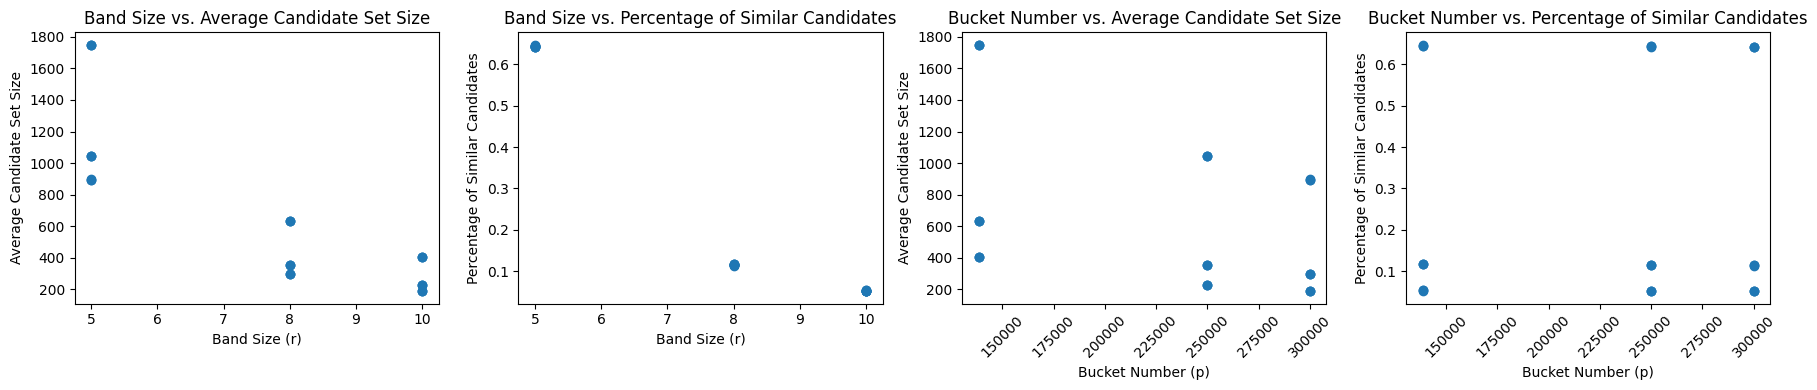

In [ ]:
# Create plots
fig, axes = plt.subplots(1,4,figsize=(18,4))

# Create scatter plot of band size r and average candidate set size
axes[0].scatter(LSH_results_df['r'], LSH_results_df['avg_candidate_set_size'])
axes[0].set_xlabel('Band Size (r)')
axes[0].set_ylabel('Average Candidate Set Size')
axes[0].set_title('Band Size vs. Average Candidate Set Size')

# Create scatter plot of band size r and percentage of similar candidates
axes[1].scatter(LSH_results_df['r'], LSH_results_df['percentage_similar_candidates'])
axes[1].set_xlabel('Band Size (r)')
axes[1].set_ylabel('Percentage of Similar Candidates')
axes[1].set_title('Band Size vs. Percentage of Similar Candidates')

# Create scatter plot of bucket number p and average candidate set size
axes[2].scatter(LSH_results_df['p'], LSH_results_df['avg_candidate_set_size'])
axes[2].set_xlabel('Bucket Number (p)')
axes[2].set_ylabel('Average Candidate Set Size')
axes[2].set_title('Bucket Number vs. Average Candidate Set Size')
axes[2].tick_params(axis='x', labelrotation=45)

# Create scatter plot of bucket number p and percentage of similar candidates
axes[3].scatter(LSH_results_df['p'], LSH_results_df['percentage_similar_candidates'])
axes[3].set_xlabel('Bucket Number (p)')
axes[3].set_ylabel('Percentage of Similar Candidates')
axes[3].set_title('Bucket Number vs. Percentage of Similar Candidates')
axes[3].tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

In the trials of the experiment we can clearly see the trade-off between band size (and therefore threshold) and average candidate set size. The higher we pick the threshold, the smaller the candidate sets, because it becomes more unlikely for users to fall into the same bucket (they need to have many more movies in common). We can also see the effect of varying the number of buckets. The higher the range of buckets, the more unlikely collisions become, and the smaller the candidate sets will be on average. We get the best results for choosing a large number of buckets ```p``` and small ```r```. In particular, for ```r=5```, ```p=300007```, ```seed=999```, we get an average candidate set size of 897.638422, with a percentage of similar users hashed to the same buckets of still about 64%. If we wanted to increase this percentage, we would have to decrease r, which, however, would make the average candidate set size grow. Since the total number of users is around $10^6$, we can quickly run into memory problems.

Since varying ```p``` has not influenced the percentage similar users hashed into the same buckets much, but significantly decreased the average candidate set size, we could try increasing it even further. We will fix ```r=5``` and ```seed=999``` for this, and test the LSH on even larger values of ```p```.

In [ ]:
r = 5
p_values2 = [400009, 500009, 1000003, 2000033]
seed = 999

LSH_results2 = [] # Initialize list to store results

# Iterate over band sizes p
for p in tqdm(p_values2):
    # Evaluate LSH performance
    avg_candidate_set_size, percentage_similar_candidates = LSH_performance(signature_matrix, user_ids, similar_pairs, r, p, seed)
    # Add information to results
    LSH_results2.append((r, p, seed, avg_candidate_set_size, percentage_similar_candidates))

# Create results dataframe
LSH_results_df2 = pd.DataFrame(LSH_results2, columns = ['r', 'p', 'seed', 'avg_candidate_set_size', 'percentage_similar_candidates'])

# Print results
display(LSH_results_df2)

  0%|          | 0/4 [00:00<?, ?it/s]

Computed LSH, now evaluating performance


 25%|██▌       | 1/4 [02:12<06:37, 132.34s/it]

Computed LSH, now evaluating performance


 50%|█████     | 2/4 [04:22<04:22, 131.17s/it]

Computed LSH, now evaluating performance


 75%|███████▌  | 3/4 [06:25<02:07, 127.13s/it]

Computed LSH, now evaluating performance


100%|██████████| 4/4 [08:18<00:00, 124.61s/it]


,r,p,seed,avg_candidate_set_size,percentage_similar_candidates
0,5,400009,999,713.216798,0.642003
1,5,500009,999,603.439871,0.642142
2,5,1000003,999,382.078488,0.642837
3,5,2000033,999,271.788249,0.641446


Increasing ```p``` allowed us to decrease the candidate set size even more, despite not modifying the percentage of similar candidates hashed together much. For ```r=5```, ```seed=999```, ```p=2000033```, we get the best results, so let us use these parameters. We can also verify that each user has some candidates in their set:

In [28]:
r = 5
seed = 999
p = 2000033

# Apply LSH algorithm to the signature matrix with these parameters
buckets, candidates = LSH(signature_matrix, user_ids, r, p, seed)

# Create dataframe to store the users and candidates with potential similarity to them
candidates_df = pd.DataFrame(candidates.items(), columns = ['User', 'Candidates'])
candidates_df['NumCandidates'] = candidates_df['Candidates'].apply(len)

print('Minimum candidate set size: ', min(candidates_df['NumCandidates']))

Minimum candidate set size:  63


### 2. Query

Now that we created buckets and candidate sets for all users, we will implement a simple user interface that finds the two users most similar to an input query user.

In [30]:
# Look up the two most similar users to a given user
query = 31415 # query user
two_most_similar_users = find_two_most_similar_users(query, candidates, user_ids, user_movies_dict) # find most similar users
print('Two most similar users to user {}:'.format(query))
display(two_most_similar_users)

Two most similar users to user 31415:


,User,Similarity
0,127242,0.456522
1,117912,0.444444


### 3. + 4. Movie Recommendation Logic + Final Recommendation

With the two most similar users to a query user, we now want to see if the two users have a rated movie in common. If so, we will recommend the movie based on the average rating. Should there be no commonly rated movies, we will recommend the top-rated movies of the most similar user. We limit the number of recommendations to 5 here. The functions used to recommend movies are implemented in the separate ```recommendations.py``` module

In [106]:
# Query user
query_user1 = 31415
query_user2 = 27182
query_user3 = 16180
# Print recommended movies for user
print(f'Movies Recommended to User {query_user1}:')
movie_recs1 = recommend_movies(query_user1, candidates, user_ids, user_movies_dict, rating, movie)
display(movie_recs1)
print(f'\nMovies Recommended to User {query_user2}:')
movie_recs2 = recommend_movies(query_user2, candidates, user_ids, user_movies_dict, rating, movie)
display(movie_recs2)
print(f'\nMovies Recommended to User {query_user3}:')
movie_recs3 = recommend_movies(query_user3, candidates, user_ids, user_movies_dict, rating, movie)
display(movie_recs3)

Movies Recommended to User 31415:


,movie,rating
7,"Shawshank Redemption, The",5.0
3,Pulp Fiction,4.5
6,Stargate,4.5
15,Forrest Gump,4.5
17,"Lion King, The",4.5



Movies Recommended to User 27182:


,movie,rating
35,"Shawshank Redemption, The",5.0
61,Hoop Dreams,5.0
64,"Piano, The",4.5
22,Babe,4.5
12,"Madness of King George, The",4.5



Movies Recommended to User 16180:


,movie,rating
0,Forrest Gump,4.50
2,Braveheart,4.50
5,"Silence of the Lambs, The",4.50
7,While You Were Sleeping,4.25
3,Schindler's List,4.25
